# Digit Recognizer
The MNIST dataset is a collecction of 28x28 pixel images of handwritten single-digit numbers. We will develop a deep neural network that classifies these images from 0 to 9. 

We begin by:
* Loading the necessary modules
* Loading and preprocessing the training data, label data and test data into separate variables

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils

train_data = np.genfromtxt('../input/digit-recognizer/train.csv', delimiter=',', skip_header = 1)
Y = train_data[:,:1]
Y = Y.reshape((Y.shape[0], 1))
Y = np_utils.to_categorical(Y)
X = train_data[:,1:]
X = X.reshape((X.shape[0], 28, 28, 1))
X = X/255

test_data = np.genfromtxt('../input/digit-recognizer/test.csv', delimiter=',', skip_header = 1)
X_test = test_data[:,:]
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
X_test = X_test/255

Y[0:2]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

The below code cell allows us to observe the images in the training data. As the example below shows, the 4th image (index 3) in the dataset is a handwritten character 4, labeled likewise.

4.0


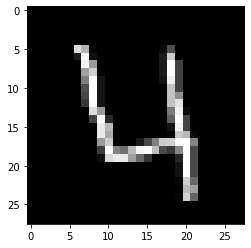

In [44]:
import matplotlib.pyplot as plt
img_num = 3
plt.imshow(X[img_num].reshape(28,28), cmap='gray',interpolation='none')
print(train_data[img_num][0])

# Developing the model

We now develop a function that fits a training model to the training data and returns the corresponding statistics such as loss and validation accuracy at each epoch of model training. The function runs a simple model that contains 2 convolutional layers and 1 fully connected layer, each with ReLU activation. These are followed by 1 fully connected layer of Softmax activation which gives us the final result. Max pooling is done between the convolutional layers and Batch normalization is done at every step.

The purpose of this function is to test different hyperparameters to develop the most accurate model.

In [19]:
def run_model(cat_size, num_filter_1, num_filter_2, ksize_1, ksize_2, dense_size):
    base_model = Sequential()
    base_model.add(Conv2D(num_filter_1, 
                          kernel_size = ksize_1,
                          strides = 1,
                          activation = 'relu',
                          input_shape = (28,28,1))
                  )
    base_model.add(MaxPooling2D(pool_size=(2, 2), padding = 'valid'))
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(num_filter_2, 
                          kernel_size = ksize_2,
                          strides = 1,
                          activation = 'relu',)
                  )
    base_model.add(BatchNormalization())
    base_model.add(Flatten())
    base_model.add(Dense(dense_size, activation = "relu"))
    base_model.add(BatchNormalization())
    base_model.add(Dense(cat_size, activation = 'softmax'))

    base_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    result = (base_model.fit(X, Y, batch_size=32, epochs=15, validation_split = 0.2, verbose = 0))
    return result

Tuning the filter sizes for the 2 convolutional networks:

In [24]:
cat_size = 10
num_filter_1 = 16
num_filter_2 = 32
ksize_1 = 3
ksize_2 = 5
dense_size = 32

ksize_list = [(3, 3), (3, 5), (5, 5)]
for ksize_1, ksize_2 in ksize_list:
    result = run_model(cat_size, num_filter_1, num_filter_2, ksize_1, ksize_2, dense_size)
    print("Filter1: " + str(ksize_1) + " Filter2: " + str(ksize_2) + " Val_acc: " + str(max(result.history['val_accuracy'])))

Filter1: 3 Filter2: 3 Val_acc: 0.989047646522522
Filter1: 3 Filter2: 5 Val_acc: 0.9901190400123596
Filter1: 5 Filter2: 5 Val_acc: 0.9903571605682373


Tuning the number of channels in the 2 convolutional layers:

In [26]:
ksize_1 = 5
ksize_2 = 5
num_filter_list = [(8,16), (16,32), (32,64), (64,128)]
for num_filter_1, num_filter_2 in num_filter_list:
    result = run_model(cat_size, num_filter_1, num_filter_2, ksize_1, ksize_2, dense_size)
    print("Channel1: " + str(num_filter_1) + " Channel2: " + str(num_filter_2) + " Val_acc: " + str(max(result.history['val_accuracy'])))

Channel1: 8 Channel2: 16 Val_acc: 0.9900000095367432
Channel1: 16 Channel2: 32 Val_acc: 0.991190493106842
Channel1: 32 Channel2: 64 Val_acc: 0.9916666746139526
Channel1: 64 Channel2: 128 Val_acc: 0.9915476441383362


Tuning the number of nodes in the ReLU fully connected layer:

In [27]:
num_filter_1 = 32
num_filter_2 = 64
dense_list = [16, 32, 64, 128, 256, 512, 1024]
for dense_size in dense_list:
    result = run_model(cat_size, num_filter_1, num_filter_2, ksize_1, ksize_2, dense_size)
    print("Dense_size: " + str(dense_size) + " Val_acc: " + str(max(result.history['val_accuracy'])))

Dense_size: 16 Val_acc: 0.991190493106842
Dense_size: 32 Val_acc: 0.9922618865966797
Dense_size: 64 Val_acc: 0.9920238256454468
Dense_size: 128 Val_acc: 0.9921428561210632
Dense_size: 256 Val_acc: 0.9915476441383362
Dense_size: 512 Val_acc: 0.9920238256454468
Dense_size: 1024 Val_acc: 0.9905952215194702


# Training the model

When choosing the best hyperparameters above, along with model accuracy, we also give consideration to model training time. Hence, in some cases, we chose hyperparameters that were not the best in accuracy. The increase in accuracy was not significant enough to warrant the increase in computational load. 

We now fit the model to the training data with the most effective hyperparameters we found. 

In [29]:
ksize_1 = 5
ksize_2 = 5
num_filter_1 = 32
num_filter_2 = 64
dense_size = 32

self_model = Sequential()
self_model.add(Conv2D(num_filter_1, 
                      kernel_size = ksize_1,
                      strides = 1,
                      activation = 'relu',
                      input_shape = (28,28,1))
              )
self_model.add(MaxPooling2D(pool_size=(2, 2), padding = 'valid'))
self_model.add(BatchNormalization())
self_model.add(Conv2D(num_filter_2, 
                      kernel_size = ksize_2,
                      strides = 1,
                      activation = 'relu',)
              )
self_model.add(BatchNormalization())
self_model.add(Flatten())
self_model.add(Dense(dense_size, activation = "relu"))
self_model.add(BatchNormalization())
self_model.add(Dense(cat_size, activation = 'softmax'))

self_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

self_model.fit(X, Y, batch_size=32, epochs=15, validation_split = 0.2)

Epoch 1/15
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1322 - accuracy: 0.9651 - val_loss: 0.0544 - val_accuracy: 0.9839
Epoch 2/15
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0458 - accuracy: 0.9864 - val_loss: 0.0469 - val_accuracy: 0.9861
Epoch 3/15
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0305 - accuracy: 0.9909 - val_loss: 0.0387 - val_accuracy: 0.9877
Epoch 4/15
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0250 - accuracy: 0.9926 - val_loss: 0.0412 - val_accuracy: 0.9890
Epoch 5/15
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0194 - accuracy: 0.9939 - val_loss: 0.0630 - val_accuracy: 0.9825
Epoch 6/15
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0173 - accuracy: 0.9950 - val_loss: 0.0362 - val_accuracy: 0.9906
Epoch 7/15
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0.0598 - val_accuracy:

The model is estimated to give an accuracy of about 0.99 on the test data. We run the model on the test data and save the results to a CSV file for submission.

In [30]:
preds = self_model.predict_classes(X_test)
img_id = np.array(range(0, X_test.shape[0]))
img_id += 1
preds_id = np.vstack((img_id, preds)).T.astype(int)
preds_pd = pd.DataFrame(preds_id, columns = ['ImageId', 'Label'])
preds_pd.set_index('ImageId', inplace = True)
preds_pd.to_csv('output_base.csv')

# Using a pretrained model

We now use the pretrained ResNet50 model and adjust it to solve our problem. We then compare the performance of our custom model with that of the ResNet50 architecture. 

* We adjust our input data by padding it with 2 layers to meet the minimum 32 x 32 pixel size needed for ResNet50. We then duplicate every image into 3 channels as this architecture only works on 3 channel images.
* We remove the final layer of the ResNet50 model, and replace it with 2 dense ReLU layers followed by one Softmax layer with 10 classes.
* We then train the entire model on our training data. Since it already contains the pretrained weights, the training time should not be very high.

In [33]:
from keras.applications import ResNet50

num_classes = 10

npad = ((0, 0), (2, 2), (2, 2), (0, 0))
X_pad = np.pad(X, pad_width=npad, mode='constant', constant_values=0)
X_mnet = np.repeat(X_pad, 3, -1)

model = Sequential()
model.add(ResNet50(include_top = False, input_shape = (32,32,3)))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_mnet, Y, batch_size = 64, epochs = 7, validation_split = 0.2)


Epoch 1/7
525/525 [==============================] - 24s 46ms/step - loss: 0.3227 - accuracy: 0.9269 - val_loss: 2.5242 - val_accuracy: 0.2395
Epoch 2/7
525/525 [==============================] - 23s 44ms/step - loss: 0.2050 - accuracy: 0.9591 - val_loss: 0.2209 - val_accuracy: 0.9368
Epoch 3/7
525/525 [==============================] - 23s 43ms/step - loss: 0.0788 - accuracy: 0.9788 - val_loss: 0.0585 - val_accuracy: 0.9838
Epoch 4/7
525/525 [==============================] - 23s 44ms/step - loss: 0.0748 - accuracy: 0.9830 - val_loss: 0.0798 - val_accuracy: 0.9796
Epoch 5/7
525/525 [==============================] - 23s 43ms/step - loss: 0.0476 - accuracy: 0.9870 - val_loss: 0.0563 - val_accuracy: 0.9867
Epoch 6/7
525/525 [==============================] - 23s 44ms/step - loss: 0.0484 - accuracy: 0.9873 - val_loss: 0.1249 - val_accuracy: 0.9706
Epoch 7/7
525/525 [==============================] - 23s 44ms/step - loss: 0.0551 - accuracy: 0.9858 - val_loss: 0.0598 - val_accuracy: 0.9846

In [34]:
npad = ((0, 0), (2, 2), (2, 2), (0, 0))
X_test_pad = np.pad(X_test, pad_width=npad, mode='constant', constant_values=0)
X_test_rnet = np.repeat(X_test_pad, 3, -1)
preds = model.predict_classes(X_test_rnet)

img_id = np.array(range(0, X_test.shape[0]))
img_id += 1
preds_id = np.vstack((img_id, preds)).T.astype(int)
preds_id_pd = pd.DataFrame(preds_id, columns = ['ImageId', 'Label'])
preds_id_pd.set_index('ImageId', inplace = True)
preds_id_pd.to_csv('output_rn50.csv')

# Final Results

This model can be estimated to give an accuracy of 0.97-0.98 on the test data. In fact, when the results were submitted on Kaggle:
* The custom model had a test accuracy of 0.99075
* The ResNet50 model had a test accuracy of 0.98585.

A possible explanation for the way more advanced ResNet50 architecture to work more poorly on the training data could be that our original inupt data of 28x28x1 images contains too less data for this 50 layer deep model to train effectively on. The ResNet was built for RGB images of size 224x224, hence the model may have overfit our data.